In [27]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters
from skimage.transform import resize, rotate
import pandas as pd
import os as os
from src import transform_image
from PIL import Image
from sklearn import decomposition, datasets
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans

In [4]:
#list of ruled and unruled images to check length for imbalanced classes

ruled_dir = "images/Ruled"
unruled_dir = 'images/Unruled'

ruled_images = []
unruled_images = []

for file in os.listdir(ruled_dir):
    ruled_images.append(file)

for file in os.listdir(unruled_dir):
    unruled_images.append(file)

In [5]:
len(ruled_images), len(unruled_images)

(454, 669)

### Question! Ruled images =454, Unruled images = 669 .....Do i need to worry about imbalanced classes? (dont think so due to unsupervised learning??)


## Notes: 

dont need to worry about imbalance until 80/20

In [39]:
#using PIL to open images
file_name = os.path.join(ruled_dir, 'IMG_0003.jpg')
sketch_grey = np.array(Image.open(file_name)) 

In [40]:
print('Type: {}'.format(type(sketch_grey)))
print('Shape: {}'.format(sketch_grey.shape))

Type: <class 'numpy.ndarray'>
Shape: (500, 400)


## Now lets try to find the edges and featurize them...

skimage.filters.sobel_h(image[, mask]) - Find the horizontal edges of an image using the Sobel transform.

skimage.filters.sobel_v(image[, mask]) - Find the vertical edges of an image using the Sobel transform.

In [41]:
#create sobel features


sobel_h =filters.sobel_h(sketch_grey)
sobel_v =filters.sobel_v(sketch_grey)
sobel = filters.sobel(sketch_grey)


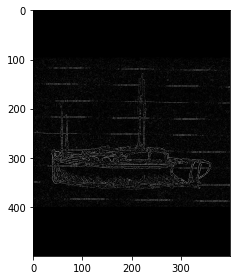

In [42]:
io.imshow(sobel)

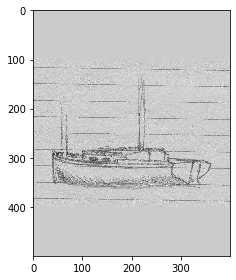

In [43]:
#for presentation
io.imshow(sketch_grey)


Lossy conversion from float64 to uint8. Range [-0.5274509803921569, 0.4882352941176471]. Convert image to uint8 prior to saving to suppress this warning.


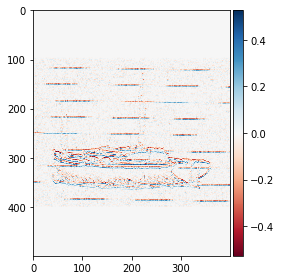

In [44]:
#for presentation
io.imshow(sobel_h);
io.imsave('images/sample_sobel_h.png',sobel_h)

Lossy conversion from float64 to uint8. Range [-0.5284313725490196, 0.4696078431372549]. Convert image to uint8 prior to saving to suppress this warning.


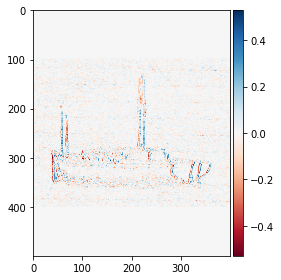

In [45]:
#for presentation
io.imshow(sobel_v);
io.imsave('images/sample_sobel_v.png',sobel_v)

In [46]:
sobel

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.96261557e-17, 1.96261557e-17, ...,
        1.96261557e-17, 1.96261557e-17, 0.00000000e+00],
       [0.00000000e+00, 1.96261557e-17, 1.96261557e-17, ...,
        1.96261557e-17, 1.96261557e-17, 0.00000000e+00],
       ...,
       [0.00000000e+00, 1.96261557e-17, 1.96261557e-17, ...,
        1.96261557e-17, 1.96261557e-17, 0.00000000e+00],
       [0.00000000e+00, 1.96261557e-17, 1.96261557e-17, ...,
        1.96261557e-17, 1.96261557e-17, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [47]:
sobel_h.flatten()

array([0., 0., 0., ..., 0., 0., 0.])

In [48]:
#NOW Create a data frame with all of the features for that image
#add regular sobel 
x = []
y = []



for i in range(sketch_grey.shape[0]):
    for j in range(sketch_grey.shape[1]):
        x.append(j)
        y.append(i)
        
        #sobel.append(sobel[i,j])
df = pd.DataFrame({
'x':x, 
'y':y,
'grey':sketch_grey.flatten(),
'sobel':sobel.flatten(),
'sobel_h': sobel_h.flatten(),
'sobel_v': sobel_v.flatten()})
df

,x,y,grey,sobel,sobel_h,sobel_v
0,0,0,203,0.0,0.0,0.0
1,1,0,203,0.0,0.0,0.0
2,2,0,203,0.0,0.0,0.0
3,3,0,203,0.0,0.0,0.0
4,4,0,203,0.0,0.0,0.0
...,...,...,...,...,...,...
199995,395,499,203,0.0,0.0,0.0
199996,396,499,203,0.0,0.0,0.0
199997,397,499,203,0.0,0.0,0.0
199998,398,499,203,0.0,0.0,0.0


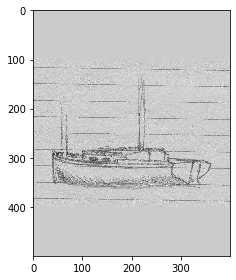

In [49]:
#turn back into an image

new_image = df['grey'].values.reshape(sketch_grey.shape)
io.imshow(new_image)

In [50]:
#PCA to remove features and to standardize
pca = PCA(whiten=True).fit_transform(df[['grey', 'sobel', 'sobel_h', 'sobel_v']])



In [51]:
pca.shape

(200000, 4)

In [58]:
df['labels'] = KMeans(n_clusters=3).fit(pca).labels_

In [59]:
df

,x,y,grey,sobel,sobel_h,sobel_v,labels
0,0,0,203,0.0,0.0,0.0,1
1,1,0,203,0.0,0.0,0.0,1
2,2,0,203,0.0,0.0,0.0,1
3,3,0,203,0.0,0.0,0.0,1
4,4,0,203,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...
199995,395,499,203,0.0,0.0,0.0,1
199996,396,499,203,0.0,0.0,0.0,1
199997,397,499,203,0.0,0.0,0.0,1
199998,398,499,203,0.0,0.0,0.0,1


/Users/megan/opt/anaconda3/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


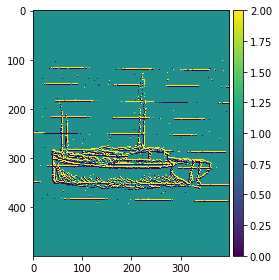

In [60]:
io.imshow(df['labels'].values.reshape(sketch_grey.shape))

In [63]:
exp_var_ratio = pca.explained_variance_ratio_
exp_sing_vals = pca.singular_values_
# df = X (why am i doing this?)

In [ ]:
#k means clustering 